# Hands-On 5: Basic Hybrid Application MPI+OpenMP

This Hands-on comprises 2 session. Next table shows the documents and
files needed to develop in the exercises.

|  Sessions      | Codes                  | files              | 
| -------------- | -----------------------| ------------------ |
| Session 1      | Hello World            | hello-mpi+openmp.c                             |
| Session 2      | Hybrid Matrix Multiple | mm-mpi.c, mm-openmp.c, and mm-mpi+openmp.c |

First, we will execute a sample hybrid code *Hello World* to understand the meaning of heterogeneous environment applied in Parallel Computing.


## `Hello World!` 

In [1]:
%%writefile ./material/hello-mpi+openmp.c
#include <mpi.h>
#include <omp.h>
#include <stdio.h>
#include <stdlib.h>

int main( int argc, char *argv[])
{
    int nthreads,nprocs,idpro,idthr;
    int  namelen;
    char processor_name[MPI_MAX_PROCESSOR_NAME];

    MPI_Init(&argc,&argv);
    MPI_Comm_size(MPI_COMM_WORLD,&nprocs);
    MPI_Comm_rank(MPI_COMM_WORLD,&idpro);
    MPI_Get_processor_name(processor_name,&namelen);

    #pragma omp parallel private(idthr) firstprivate(idpro,processor_name)
    {
    idthr = omp_get_thread_num();
    printf("Hello World  thread %d,From %d processor %s\n",idthr,idpro, processor_name);
    }

    MPI_Finalize();
}

Overwriting ./material/hello-mpi+openmp.c


### Run the code

In [2]:
!mpicc ./material/hello-mpi+openmp.c -o ./material/hello-mpi+openmp -fopenmp

In [8]:
!OMP_NUM_THREADS=2 mpirun -np 2 ./material/hello-mpi+openmp

Hello World  thread 0,From 0 processor aquario
Hello World  thread 1,From 0 processor aquario
Hello World  thread 0,From 1 processor aquario
Hello World  thread 1,From 1 processor aquario


##  `Matrix Multiple Benchmarks`

### OpenMP

In [70]:
%%writefile ./material/mm-openmp.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

void writeResultsToFile(int size, double time_spend, int num_threads) {
    FILE *output_file = fopen("./output/mm_openMP.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    } 

    fprintf(output_file, "%d %lf %d ", size, time_spend, num_threads);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void initializeMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
    for (int j = 0; j < size; j++)
      matrix[i * size + j] = rand() % (10 - 1) * 1;
}

void printMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
  {
    for (int j = 0; j < size; j++)
      printf("%d\t", matrix[i * size + j]);
    printf("\n");
  }
  printf("\n");
}

int main (int argc, char **argv)
{

 int size = atoi(argv[1]);  
 int i, j, k;
 double t1, t2;

 int  *A = (int *) malloc (sizeof(int)*size*size);
 int  *B = (int *) malloc (sizeof(int)*size*size);
 int  *C = (int *) malloc (sizeof(int)*size*size);

 initializeMatrix(A, size);
 initializeMatrix(B, size);

 t1 = omp_get_wtime();

  int num_threads = 0;

 #pragma omp parallel for private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      for(k = 0; k < size; k++){
        C[i * size + j] += A[i * size + k] * B[k * size + j];
        if(i==0 && j==0 && k == 0)num_threads = omp_get_num_threads();
      }     
    }  
  }
 
 t2 = omp_get_wtime();

 printf("%d\t%f\n",size, t2-t1);

// printMatrix(A,size);
// printMatrix(B,size);
// printMatrix(C,size);

writeResultsToFile(size, t2-t1, num_threads);

 return 0;

}

Overwriting ./material/mm-openmp.c


#### Run the code

In [71]:
!gcc ./material/mm-openmp.c -o ./material/mm -fopenmp

# Performance analysis

In [72]:
%%writefile ./bash/script.sh
#!/bin/sh

for ((i=2; i<=64; i*=2))
do
  echo "Number of threads:" $i "=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-="  
  for ((j=200; j<=1000; j+=200))
  do
    OMP_NUM_THREADS="$i" ./material/mm "$j"
  done
  echo 
done

Overwriting ./bash/script.sh


In [73]:
!bash ./bash/script.sh

Number of threads: 2 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.013609
400	0.109538
600	0.397798
800	0.865606
1000	1.719676

Number of threads: 4 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.007214
400	0.054134
600	0.186989
800	0.454182
1000	0.861121

Number of threads: 8 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.005126
400	0.040161
600	0.135383
800	0.314958
1000	0.587592

Number of threads: 16 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.005203
400	0.036882
600	0.139200
800	0.248614
1000	0.490401

Number of threads: 32 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.004581
400	0.032704
600	0.104204
800	0.255592
1000	0.489327

Number of threads: 64 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
200	0.005348
400	0.032181
600	0.114458
800	0.262933
1000	0.466569



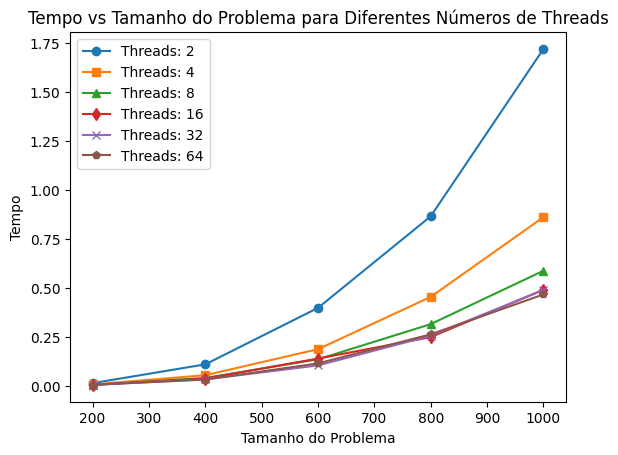

In [76]:
import matplotlib.pyplot as plt

file_name = "./output/mm_openMP.txt"

# Ler o arquivo e armazenar os dados
dados = {}
with open(file_name, 'r') as file:
    for line in file:
        valores = line.split()
        for i in range(0, len(valores), 3):
            tamanho = float(valores[i])
            tempo = float(valores[i + 1])
            threads = float(valores[i + 2])
            if threads in dados:
                dados[threads].append((tamanho, tempo))
            else:
                dados[threads] = [(tamanho, tempo)]

# Opções de estilo para as linhas do gráfico
estilos = ['o-', 's-', '^-', 'd-', 'x-', 'p-', 'h-', '+-']
estilo_idx = 0

# Ordenar os dados e criar o gráfico
for threads, valores in dados.items():
    if estilo_idx >= len(estilos):
        estilo_idx = 0  # Resetar o índice de estilos se tiver mais linhas que estilos disponíveis
    valores.sort(key=lambda x: x[0])  # Ordenar pelo tamanho
    tamanhos = [x[0] for x in valores]
    tempos = [x[1] for x in valores]
    plt.plot(tamanhos, tempos, estilos[estilo_idx], label=f'Threads: {int(threads)}')
    estilo_idx += 1

# Configurar e mostrar o gráfico
plt.xlabel('Tamanho do Problema')
plt.ylabel('Tempo')
plt.title('Tempo vs Tamanho do Problema para Diferentes Números de Threads')
plt.legend()
plt.show()



### MPI

In [6]:
%%writefile ./material/mm-mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>

void mms(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc) {
    int i, j, k;
    double s;
    for (i = 0; i < fa; i++) 
        for (j = 0; j < cb; j++) {
            s = 0.;
            for (k = 0; k < ca; k++)
                s += a[i * lda + k] * b[k * ldb + j];
            c[i * ldc + j] = s;
        }
}

void mm(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc, int nodo, int np) {
    int i, j, k;
    double s;
    if (nodo == 0) {
        for (i = 1; i < np; i++)
            MPI_Send(&a[i * lda * fa / np], fa / np * ca, MPI_DOUBLE, i, 20, MPI_COMM_WORLD);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    } else {
        MPI_Recv(a, fa / np * ca, MPI_DOUBLE, 0, 20, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    }
    mms(a, fa / np, ca, lda, b, fb, cb, ldb, c, fc / np, cc, ldc);
    if (nodo == 0)
        for (i = 1; i < np; i++)
            MPI_Recv(&c[i * ldc * fc / np],fc / np * cc, MPI_DOUBLE, i, 30, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    else
        MPI_Send(c, fc / np * cc, MPI_DOUBLE, 0, 30, MPI_COMM_WORLD);
}

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      m[i * ld + j] = (double)(i + j);
    }
  }
}

void initializealea(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      m[i * ld + j] = (double)rand() / RAND_MAX;
    }
  }
}

void escribir(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {  
      printf("%.4lf ",m[i * ld + j]);
    }
    printf("\n");
  }
}

void comparar(double *m1, int fm1, int cm1, int ldm1, double *m2, int fm2, int cm2, int ldm2)
{
  int i, j;

  for(i = 0; i < fm1; i++)
    for(j = 0; j < cm1; j++) {
      if(m1[i * ldm1 + j] != m2[i * ldm2 + j]) {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n", i, j, m1[i * ldm1 + j], m2[i * ldm2 + j]);
        return;
      }
    }
}

int main(int argc, char *argv[]) {
  int nodo, np, i, j, fa, fal, ca, lda, fb, cb, ldb, fc, fcl, cc, ldc, N;
  int long_name;
  double ti, tf;
  double *a, *b, *c, *c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;
 
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &nodo);
  MPI_Get_processor_name(nombre_procesador, &long_name);

  if (nodo == 0) {
    N = atoi(argv[1]);
  }
  MPI_Bcast(&N, 1, MPI_INT, 0, MPI_COMM_WORLD);
  
  fa = ca = lda = fb = cb = ldb = fc = cc = ldc = N;
  fal = N / np;
  fcl = N / np;
  if (nodo == 0) {
    a = (double *) malloc(sizeof(double) * fa * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fc * cc);
  } else {
    a = (double *) malloc(sizeof(double) * fal * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fcl * cc);
  }
  
  if (nodo == 0) {
    c0 = (double *) malloc(sizeof(double) * fc * cc);
    initialize(a, fa, ca, lda);
    initialize(b, fb, cb, ldb);

    mms(a, fa, ca, lda, b, fb, cb, ldb, c0, fc, cc, ldc);
  }

  MPI_Barrier(MPI_COMM_WORLD);

  ti = MPI_Wtime();

  mm(a, fa, ca, lda, b, fb, cb, ldb, c, fc, cc, ldc, nodo, np);

  MPI_Barrier(MPI_COMM_WORLD);
  tf = MPI_Wtime();
  if (nodo == 0) {
    //printf("(%d) Process %d, %s, Time %.6lf\n", N, np, nombre_procesador, tf - ti);
    printf("%d\t%f\n", N, tf - ti);  
  }
  
  free(a);
  free(b);
  free(c);
  if (nodo == 0)
    free(c0);
  MPI_Finalize();
}

Overwriting ./material/mm-mpi.c


#### Run the code

In [7]:
!mpicc ./material/mm-mpi.c -o ./material/mm-mpi

In [8]:
!mpirun -np 4 ./material/mm-mpi  1000

1000	0.764462


### MPI + OpenMP

In [15]:
%%writefile mm-mpi+openmp.c

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>
#include <omp.h>

void mm(double *a, int fa,int ca,int lda,double *b,int fb,int cb,int ldb,double *c,int fc,int cc,int ldc,int nodo,char *maquina)
{
  int i, j, k;
  double s;

 #pragma omp parallel 
 {
   #pragma omp for private(i,j,k,s) schedule(static)
    for (i = 0; i < fa; i++) 
    {
     for(j=0;j<cb;j++)
     {
      s=0.;
      for (k = 0; k < ca; k++)
      s = s+a[i*lda+k]*b[k*ldb+j];
      c[i*ldc+j]=s;
     }
    }
   }
  }

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      m[i*ld+j] = (double)(i+j);
    }
  }
}

void initializealea(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      m[i*ld+j] = (double)rand()/RAND_MAX;
    }
  }
    
}

void escribir(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {  
      printf("%.4lf ",m[i*ld+j]);
    }
    printf("\n");
  }
    
}
/*
c
c     mseconds - returns elapsed milliseconds since Jan 1st, 1970.
c
*/
long long mseconds(){
  struct timeval t;
  gettimeofday(&t, NULL);
  return t.tv_sec*1000 + t.tv_usec/1000;
}

void comparar(double *m1,int fm1,int cm1,int ldm1,double *m2,int fm2,int cm2,int ldm2)
{
  int i,j;

  for(i=0;i<fm1;i++)
    for(j=0;j<cm1;j++)
    {
      if(m1[i*ldm1+j]!=m2[i*ldm2+j])
      {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n",i,j,m1[i*ldm1+j],m2[i*ldm2+j]);
        return;
      }
    }
    
}

int main(int argc,char *argv[]) 
{
  int nodo,np,i, j,fa,fal,ca,lda,fb,cb,ldb,fc,fcl,cc,ldc,N,NUMTHREADS;
  int long_name;
  double ti,tf;
  double *a,*b,*c,*c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;
 
  MPI_Init(&argc,&argv);
  MPI_Comm_size(MPI_COMM_WORLD,&np);
  MPI_Comm_rank(MPI_COMM_WORLD,&nodo);
  MPI_Get_processor_name(nombre_procesador,&long_name);

  if(nodo==0)
  {
    N=atoi(argv[1]);
    NUMTHREADS=atoi(argv[2]);
  }
    
  MPI_Bcast(&N,1,MPI_INT,0,MPI_COMM_WORLD);
  MPI_Bcast(&NUMTHREADS,1,MPI_INT,0,MPI_COMM_WORLD);
  omp_set_num_threads(NUMTHREADS);
  
  fa=ca=lda=fb=cb=ldb=fc=cc=ldc=N;
  fal=N/np;
  fcl=N/np;
  if(nodo==0)
  {
    a = (double *) malloc(sizeof(double)*fa*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fc*cc);
  }
  else
  {
    a = (double *) malloc(sizeof(double)*fal*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fcl*cc);
  }
  
  if(nodo==0)
  {
    c0=(double *) malloc(sizeof(double)*fc*cc);
    initialize(a,fa,ca,lda);
    for(i=1;i<np;i++)
    {
      MPI_Send(&a[i*lda*N/np],fal*ca,MPI_DOUBLE,i,20,MPI_COMM_WORLD);
    }
    initialize(b,fb,cb,ldb);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
    mm(a,fa,ca,lda,b,fb,cb,ldb,c0,fc,cc,ldc,nodo,nombre_procesador);
  }
  else
  {
    MPI_Recv(a,fal*ca,MPI_DOUBLE,0,20,MPI_COMM_WORLD,&estado);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
  } 

  MPI_Barrier(MPI_COMM_WORLD);

  ti=MPI_Wtime();

  mm(a,fal,ca,lda,b,fb,cb,ldb,c,fcl,cc,ldc,nodo,nombre_procesador);

  MPI_Barrier(MPI_COMM_WORLD);
  tf=MPI_Wtime();
  if(nodo==0)
  {
    printf("(%d) Threads %d, Process %d, %s, Time %.6lf\n\n",N, NUMTHREADS, np, nombre_procesador,tf-ti);
    printf("%d\t%f\n", N, tf-ti);
    for(i=1;i<np;i++)
    {
      MPI_Recv(&c[i*ldc*N/np],fcl*cc,MPI_DOUBLE,i,30,MPI_COMM_WORLD,&estado);
    }
  }
  else
  {
    MPI_Send(c,fcl*cc,MPI_DOUBLE,0,30,MPI_COMM_WORLD);
  } 
  
  free(a);
  free(b);
  free(c);
  if(nodo==0)
    free(c0);
  MPI_Finalize();
}

Writing mm-mpi+openmp.c


#### Run the Code

In [9]:
!mpicc ./material/mm-mpi+openmp.c -o ./material/mm-mpi+openmp -fopenmp

In [10]:
!mpirun -np 4 ./material/mm-mpi+openmp  1000 16     

1000	0.370415


## Practice with the Benchmarks

From the parallelized matrix multiplication codes (MPI (`mm-mpi.c`), OpenMP (`mm-openmp.c)` and Hybrid (`mm-mpi+openmp.c`). Make the following plots:

-   Execution time
-   Speedup

They are comparatively commenting on the performance of the optimizations of each code, with each group doing the experimentation on a specific execution platform.

## References

M. Boratto. *Hands-On Supercomputing with Parallel Computing*.
Available:
<https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing>.
2022.

Forum, Message Passing Interface. *MPI: A Message-Passing Interface
Standard*. University of Tennessee, 1994, USA.

B. Chapman, G. Jost and R. Pas. *Using OpenMP: Portable Shared Memory
Parallel Programming*. The MIT Press, 2007, USA.